Import libraries

In [74]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# packages for hyperparameters tuning
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import os
import numpy as np

import hopsworks
import joblib

In [75]:
project = hopsworks.login()

fs = project.get_feature_store()

2025-01-08 00:55:15,969 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 00:55:15,978 INFO: Initializing external client
2025-01-08 00:55:15,979 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 00:55:17,815 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1149079


In [76]:
news_propagation_fg = fs.get_feature_group(
    name="news_propagation",
    version=1,
)

In [77]:
selected_features = news_propagation_fg.select_except(["news_id"])

In [78]:
selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.26s) 


,average_followers,average_follows,repost_total,post_total,repost_percentage,average_repost,average_favorite,label,news_lifetime,nb_users_10_hours,average_time_difference,retweet_percentage_1_hour
0,625.000000,438.000000,0,1,0.000000,0.000000,0.000000,1,0,1,0.0,1.000000
1,1410.833333,1103.416667,4,10,0.285714,0.285714,6.166667,0,63372,1,0.0,0.071429
2,536.454545,342.909091,979,1,0.998980,9.989796,499.000000,0,0,1,0.0,0.001020
3,223066.000000,178.000000,0,2,0.000000,0.000000,0.000000,0,39416,1,0.0,0.500000
4,74.500000,156.000000,0,2,0.000000,0.000000,0.000000,0,11319,1,0.0,0.500000


In [79]:
feature_view = fs.get_or_create_feature_view(
        name = 'news_propagation_feature_views',
        version = 1,
        labels=["label"],
        query=selected_features,
)

In [80]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


Hyperpameters tuning

In [81]:
tuning = False

In [ ]:
# Define the hyperparameter grid
if tuning:
    param_grid = {
        'n_estimators': [25, 50, 100, 150], 
        'max_features': ['sqrt', 'log2', None], 
        'max_depth': [3, 6, 9], 
        'max_leaf_nodes': [3, 6, 9], 
        'min_samples_leaf': [1, 2, 4],
    }

    # Create the XGBoost model object
    # model = xgb.XGBClassifier()
    model = RandomForestClassifier()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, np.ravel(y_train))

    # Print the best set of hyperparameters and the corresponding score
    print("Best set of hyperparameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

Train the model

In [63]:
random_forest = RandomForestClassifier(max_depth=grid_search.best_params_["max_depth"], 
                                       max_features = grid_search.best_params_["max_features"], 
                                       max_leaf_nodes = grid_search.best_params_["max_leaf_nodes"], 
                                       n_estimators = grid_search.best_params_["n_estimators"],
                                       min_samples_leaf=grid_search.best_params_["min_samples_leaf"],
                                       )
random_forest.fit(X_train, np.ravel(y_train))
y_pred_train = random_forest.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.7531806615776081

In [64]:
y_pred_test = random_forest.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.8421052631578947

In [65]:
y_pred_val = random_forest.predict(X_val)
accuracy_score(y_val, y_pred_val)

0.7410714285714286

In [66]:
metrics = {
    "accuracy": accuracy_score(y_test, y_pred_test)
}
metrics

{'accuracy': 0.8421052631578947}

In [67]:
results = confusion_matrix(y_test, y_pred_test)
results

array([[27,  0],
       [ 9, 21]], dtype=int64)

In [68]:
# Create a DataFrame from the confusion matrix results
df_cm = pd.DataFrame(
    results, 
    ['True Real', 'True Fake'],
    ['Pred Real', 'Pred Fake']
)

# Create and save the confusion matrix heatmap
plt.figure(figsize=(8, 6))
cm = sns.heatmap(
    df_cm, 
    annot=True,
    fmt='d',                 # Use integer format for numbers
    cmap='RdPu',             # Use a color palette that works well for binary classification
    annot_kws={'size': 12},  # Increase annotation text size
    cbar=True                # Include color bar
)

# Add title and labels
plt.title('Confusion Matrix for Fake News Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

images_dir = "figures"

# Adjust layout and save
plt.tight_layout()
plt.savefig(os.path.join(images_dir, "confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.close()

Plot feature importance

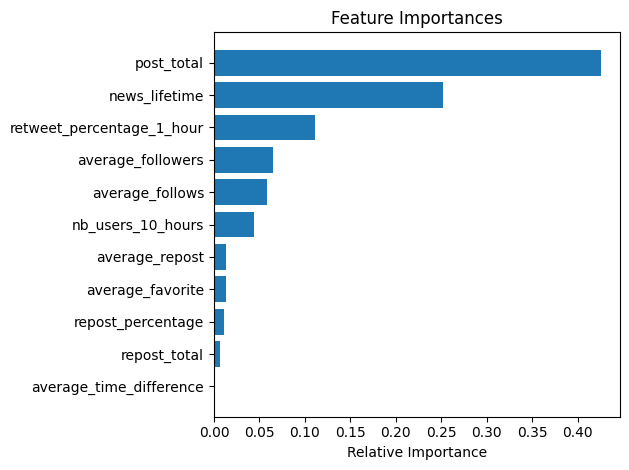

In [ ]:
images_dir = 'figures'
importances = random_forest.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

plt.tight_layout()
plt.savefig(os.path.join(images_dir, "feature_importance.png"))

Save the model into Hopsworks

In [70]:
# Get the model registry
mr = project.get_model_registry()

In [ ]:
# Create input schema using X_train
input_schema = Schema(X_train)

# Create output schema using y_train
output_schema = Schema(y_train)

# Create a ModelSchema object specifying the input and output schemas
model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

# Convert the model schema to a dictionary
model_schema.to_dict()# Specify the directory where the model files will be saved
model_dir = "news_propagation_model"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained classifier as json file
xgb.save_model(model_dir + "/model.json")
joblib.dump(random_forest, "model.joblib")

AttributeError: module 'xgboost' has no attribute 'save_model'

In [52]:
# Create a model in the model registry
model = mr.python.create_model(
    name="news_propagation_model",
    description="News Propagation Model",
    input_example=X_train.sample(),
    model_schema=model_schema,
    feature_view=feature_view,
    metrics=metrics,
)

# Save the model to the specified directory
model.save(model_dir)

Uploading: 100.000%|██████████| 195108/195108 elapsed<00:02 remaining<00:00  1.33it/s]
Uploading: 100.000%|██████████| 58/58 elapsed<00:01 remaining<00:0003<00:07,  1.85s/it]
Uploading: 100.000%|██████████| 1100/1100 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:13<00:00,  2.21s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1149079/models/news_propagation_model/14


Model(name: 'news_propagation_model', version: 14)